In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
from scipy.stats import ks_2samp, chi2_contingency
from pandas.api.types import is_numeric_dtype
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

# Split Wav Dataset for Testing and check Distribution

We use this notebook to split the Wav files in Training: 60%, Validation: 20% & Testing: 20%.

## Data import

In [2]:
meas_eurythmy_path= r"../../data/interim/measurements_with_eurythmy.csv"
columns_to_read = ['id_measurement', 'id_performance', 'datetime', 'plant', 'generation', 'num_eurythmy']

In [3]:
df = pd.read_csv(meas_eurythmy_path, usecols=columns_to_read, index_col='id_measurement')

In [4]:
df.head()

,id_performance,datetime,plant,generation,num_eurythmy
id_measurement,,,,,
1,1,2023-04-29,salad,1,1
2,1,2023-04-29,salad,1,1
3,1,2023-04-29,salad,1,1
4,1,2023-04-29,salad,2,0
5,1,2023-04-29,salad,2,0


## Split Dataset

In [5]:
# Split into test and the rest
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the rest into validation and training
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## Plot Distribution

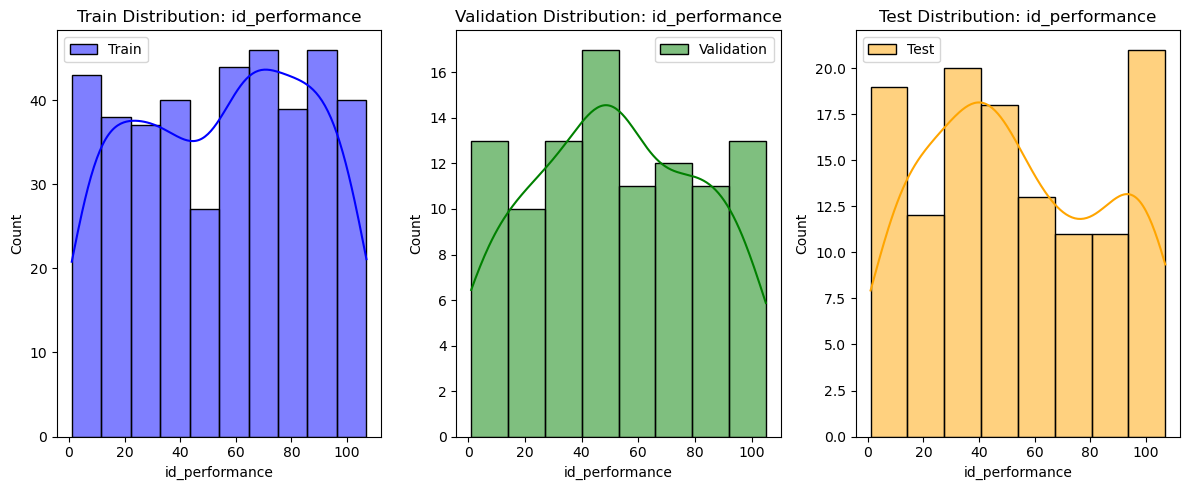

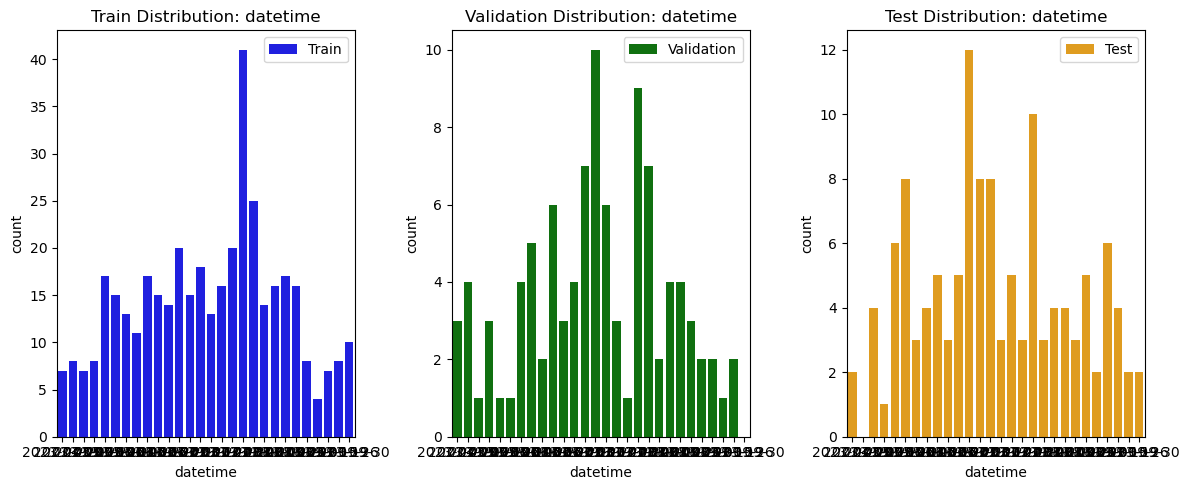

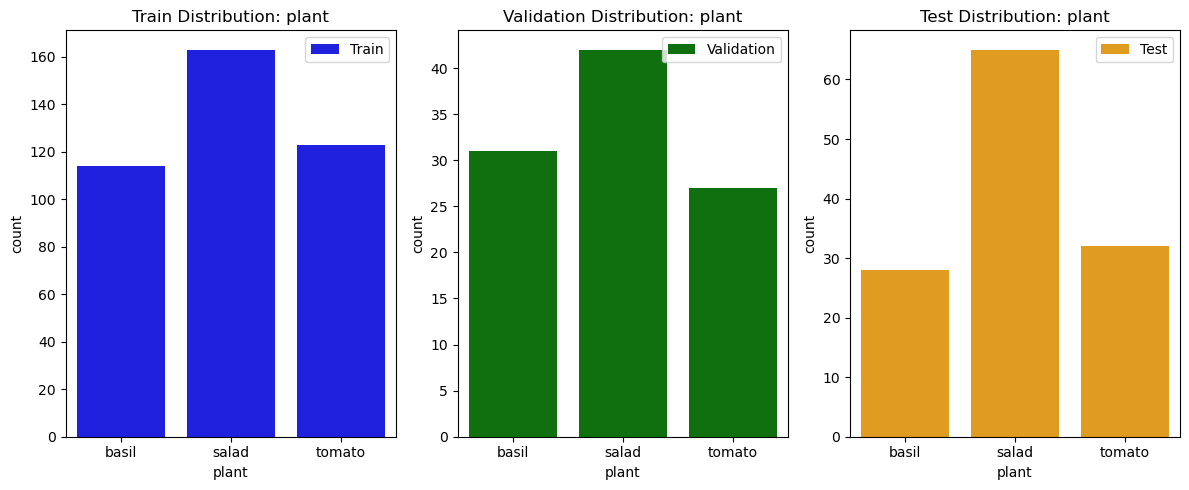

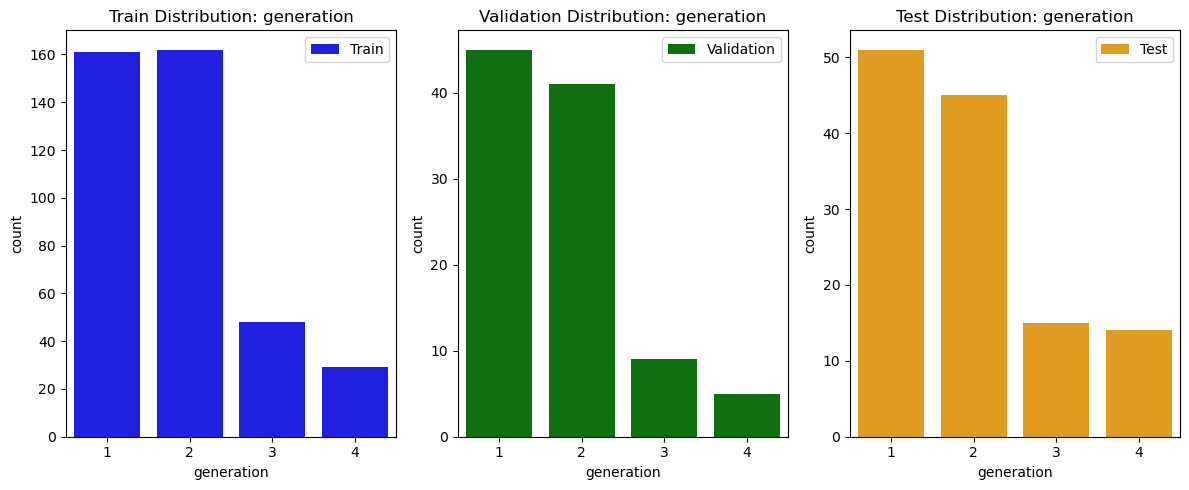

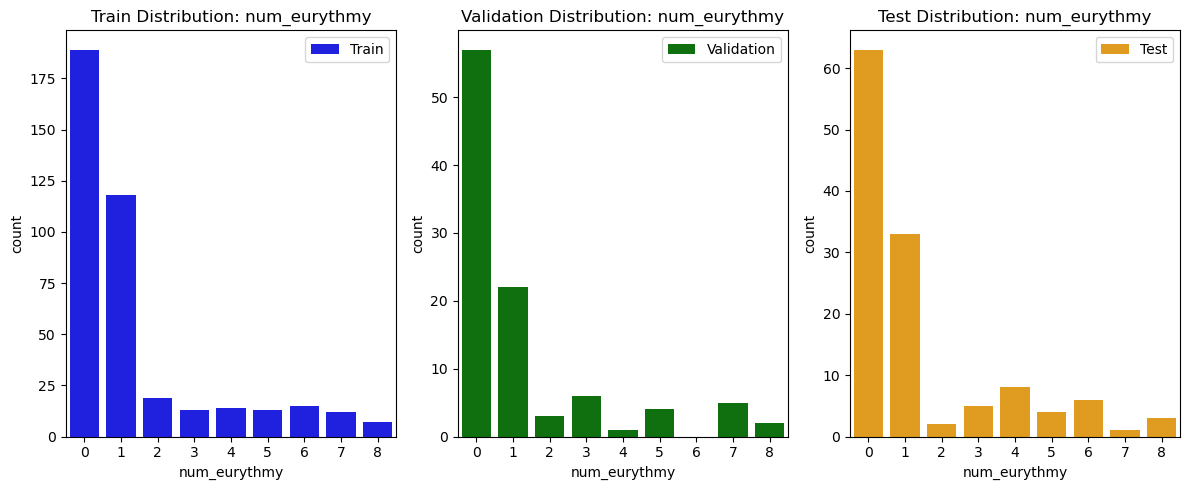

In [6]:
for column in df.columns:
    plt.figure(figsize=(12, 5))

    if df[column].dtype == 'object' or len(df[column].unique()) < 10:  # Categorical data
        order = sorted(df[column].unique())
        
        plt.subplot(1, 3, 1)
        sns.countplot(x=train_df[column], order=order, color='blue', label='Train')
        plt.title(f'Train Distribution: {column}')
        plt.legend()

        plt.subplot(1, 3, 2)
        sns.countplot(x=val_df[column], order=order, color='green', label='Validation')
        plt.title(f'Validation Distribution: {column}')
        plt.legend()

        plt.subplot(1, 3, 3)
        sns.countplot(x=test_df[column], order=order, color='orange', label='Test')
        plt.title(f'Test Distribution: {column}')
        plt.legend()

    else:  # Numerical data
        plt.subplot(1, 3, 1)
        sns.histplot(train_df[column], kde=True, color='blue', label='Train')
        plt.title(f'Train Distribution: {column}')
        plt.legend()

        plt.subplot(1, 3, 2)
        sns.histplot(val_df[column], kde=True, color='green', label='Validation')
        plt.title(f'Validation Distribution: {column}')
        plt.legend()

        plt.subplot(1, 3, 3)
        sns.histplot(test_df[column], kde=True, color='orange', label='Test')
        plt.title(f'Test Distribution: {column}')
        plt.legend()

    plt.tight_layout()
    plt.show()


## Checking there is no statistical difference

We wanted to calculate the difference just because or N is low

In [7]:
from scipy.stats import ks_2samp, chi2_contingency
from pandas.api.types import is_numeric_dtype

for column in df.columns:
    if is_numeric_dtype(df[column]):
        # Kolmogorov-Smirnov test for numerical data
        ks_statistic_train, p_value_train = ks_2samp(train_df[column].dropna(), val_df[column].dropna())
        ks_statistic_val, p_value_val = ks_2samp(val_df[column].dropna(), test_df[column].dropna())
        
        print(f"Kolmogorov-Smirnov test for {column}:")
        print(f"  Train vs. Validation - statistic={ks_statistic_train}, p-value={p_value_train}")
        print(f"  Validation vs. Test - statistic={ks_statistic_val}, p-value={p_value_val}")

        # Interpretation of the KS test result
        if p_value_train < 0.05:
            print(f"  Train vs. Validation: There is a statistical difference in the distribution of {column} (p < 0.05).\n")
        else:
            print(f"  Train vs. Validation: No statistical difference found in the distribution of {column} (p >= 0.05).")
        
        if p_value_val < 0.05:
            print(f"  Validation vs. Test: There is a statistical difference in the distribution of {column} (p < 0.05).\n")
        else:
            print(f"  Validation vs. Test: No statistical difference found in the distribution of {column} (p >= 0.05).\n")

    else:
        # Chi-squared test for categorical data
        train_counts = train_df[column].value_counts()
        val_counts = val_df[column].value_counts()
        test_counts = test_df[column].value_counts()

        # Create contingency tables
        contingency_table_train = pd.concat([train_counts, val_counts], axis=1, keys=['train', 'validation']).fillna(0)
        contingency_table_test = pd.concat([val_counts, test_counts], axis=1, keys=['validation', 'test']).fillna(0)
        
        chi2_stat_train, p_value_train, dof_train, ex_train = chi2_contingency(contingency_table_train)
        chi2_stat_test, p_value_test, dof_test, ex_test = chi2_contingency(contingency_table_test)

        print(f"Chi-squared test for {column}:")
        print(f"  Train vs. Validation - chi2_statistic={chi2_stat_train}, p-value={p_value_train}")
        print(f"  Validation vs. Test - chi2_statistic={chi2_stat_test}, p-value={p_value_test}")

        # Interpretation of the Chi-squared test result
        if p_value_train < 0.05:
            print(f"  Train vs. Validation: There is a statistical difference in the distribution of {column} (p < 0.05).\n")
        else:
            print(f"  Train vs. Validation: No statistical difference found in the distribution of {column} (p >= 0.05).")
        
        if p_value_test < 0.05:
            print(f"  Validation vs. Test: There is a statistical difference in the distribution of {column} (p < 0.05).\n")
        else:
            print(f"  Validation vs. Test: No statistical difference found in the distribution of {column} (p >= 0.05).\n")


Kolmogorov-Smirnov test for id_performance:
  Train vs. Validation - statistic=0.12, p-value=0.190325962303546
  Validation vs. Test - statistic=0.074, p-value=0.8993949450683157
  Train vs. Validation: No statistical difference found in the distribution of id_performance (p >= 0.05).
  Validation vs. Test: No statistical difference found in the distribution of id_performance (p >= 0.05).

Chi-squared test for datetime:
  Train vs. Validation - chi2_statistic=26.01490423222718, p-value=0.5177733762554717
  Validation vs. Test - chi2_statistic=32.22668233082707, p-value=0.22379289579767414
  Train vs. Validation: No statistical difference found in the distribution of datetime (p >= 0.05).
  Validation vs. Test: No statistical difference found in the distribution of datetime (p >= 0.05).

Chi-squared test for plant:
  Train vs. Validation - chi2_statistic=0.577901597981497, p-value=0.7490490584657132
  Validation vs. Test - chi2_statistic=2.776698875336608, p-value=0.2494867584188979
  T

## Get Test Ids

In [8]:
train_indexes = train_df.index.to_list()
val_indexes = val_df.index.to_list()
test_indexes = test_df.index.to_list()

indexes_path = r"../../data/interim/split_indexes.txt"

# Save all indexes in one file
with open(indexes_path, 'w') as file:
    file.write("Training Set:\n")
    for index in train_indexes:
        file.write(str(index) + '\n')
    
    file.write("\nValidation Set:\n")
    for index in val_indexes:
        file.write(str(index) + '\n')
    
    file.write("\nTest Set:\n")
    for index in test_indexes:
        file.write(str(index) + '\n')

print("\nWav files of the training set:")
print(train_indexes)
print("\nWav files of the validation set:")
print(val_indexes)
print("\nWav files of the test set:")
print(test_indexes)


Wav files of the training set:
[539, 162, 542, 234, 233, 154, 430, 384, 259, 616, 173, 217, 471, 200, 567, 184, 151, 304, 512, 408, 75, 17, 152, 350, 479, 208, 15, 603, 125, 198, 391, 431, 475, 395, 26, 76, 230, 549, 43, 572, 118, 353, 386, 368, 469, 124, 245, 602, 148, 296, 478, 279, 611, 474, 505, 66, 105, 104, 379, 69, 415, 374, 462, 80, 106, 561, 84, 495, 242, 596, 138, 405, 331, 70, 330, 606, 222, 355, 323, 237, 522, 238, 490, 325, 14, 410, 36, 417, 310, 376, 615, 96, 135, 454, 365, 267, 246, 276, 58, 171, 476, 500, 520, 95, 548, 531, 363, 361, 192, 284, 360, 624, 268, 130, 199, 62, 201, 508, 441, 37, 461, 372, 214, 599, 530, 13, 263, 2, 443, 322, 8, 299, 477, 497, 243, 286, 385, 256, 114, 49, 554, 394, 92, 305, 537, 109, 183, 564, 180, 597, 59, 343, 314, 524, 54, 65, 540, 5, 155, 455, 517, 250, 143, 168, 378, 60, 81, 55, 419, 498, 590, 354, 298, 101, 220, 484, 543, 407, 247, 150, 487, 120, 157, 427, 186, 493, 550, 35, 52, 126, 45, 450, 503, 592, 420, 570, 387, 202, 88, 492, 188,

Calculate duration of eurythmy gestures

In [9]:
# Get a new list of the column names that represent the letters
all_columns = df.columns.tolist()
start_index = all_columns.index('A1_start')
end_index = all_columns.index('eurythmy_start')-1
letters_starts_ends = all_columns[start_index:end_index]

# Create letter duration
for letter in letters_starts_ends:
    # Extract the letter identifier (assuming it's the first part of the column name)
    letter_id = letter.split('_')[0]

    # Calculate the duration and create a new column
    df[f'{letter_id}_duration'] = df[f'{letter_id}_end'] - df[f'{letter_id}_start']

# Extract unique letter identifiers
unique_letters = set(letter.split('_')[0] for letter in letters_starts_ends)

# Convert the set back to a list, if needed
unique_letters = sorted(list(unique_letters))

ValueError: 'A1_start' is not in list

Group all similar letters

In [ ]:
# Create a dictionary to store data grouped by the first letter
data_by_letter = {}

# Populate the dictionary with data
for letter in unique_letters:
    # Construct the duration column name
    duration_col = f'{letter}_duration'

    # Determine the data range and set integer bins accordingly
    data = df[duration_col].dropna().astype(int)
    
    # Get the first letter
    first_letter = letter[0]

    # Add the data to the corresponding letter's group in the dictionary
    if first_letter not in data_by_letter:
        data_by_letter[first_letter] = []
    data_by_letter[first_letter].extend(data)

Plot histograms of the letters

In [ ]:
# Create histograms for each group of letters
for first_letter, data in data_by_letter.items():
    # Determine the data range and set integer bins accordingly
    data_range = int(max(data)) - int(min(data))
    bins = np.arange(int(min(data)), int(max(data)) + 2, 1)

    # Calculate the mean of the data
    mean_value = np.mean(data)

    # Plot the histogram for the current group of letters with integer bins
    plt.figure(figsize=(8, 4))  # Optional: Adjust figure size
    n, bins, patches = plt.hist(data, bins=bins, edgecolor='black', align='left', rwidth=0.8)  # Use align='left' and adjust rwidth
    plt.title(f'Letter {first_letter} Duration')
    plt.xlabel('Seconds')
    plt.ylabel('Frequency')
    
    # Set x-axis ticks to display only integers
    plt.xticks(np.arange(int(min(data)), int(max(data)) + 1, 1))

    # Add a red vertical line for the mean
    plt.axvline(mean_value, color='lightcoral', linestyle='solid', linewidth=2, label='Mean')
    plt.legend()  # Show the legend with the mean line

    plt.show()

In [ ]:
# Create a dictionary to store data grouped by the first letter
data_by_letter = {}

# Populate the dictionary with data
for letter in unique_letters:
    # Construct the duration column name
    duration_col = f'{letter}_duration'

    # Determine the data range and set integer bins accordingly
    data = df[duration_col].dropna().astype(int)
    
    # Get the first letter
    first_letter = letter[0]

    # Add the data to the corresponding letter's group in the dictionary
    if first_letter not in data_by_letter:
        data_by_letter[first_letter] = []
    data_by_letter[first_letter].extend(data)

# Create a histogram for all letters combined
all_data = [data for data_list in data_by_letter.values() for data in data_list]
data_range = int(max(all_data)) - int(min(all_data))
bins = np.arange(int(min(all_data)), int(max(all_data)) + 2, 1)

# Calculate the mean of the data
mean_value = np.mean(all_data)

plt.figure(figsize=(8, 4))  # Optional: Adjust figure size
n, bins, patches = plt.hist(all_data, bins=bins, edgecolor='black', align='left', rwidth=0.8)
plt.title('Combined Histogram of All Letters')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.axvline(mean_value, color='lightcoral', linestyle='solid', linewidth=2, label='Mean')
plt.legend()  # Show the legend with the mean line
plt.xticks(np.arange(int(min(all_data)), int(max(all_data)) + 1, 1))

# Annotate each bar with its frequency
for count, rect in zip(n, patches):
    height = rect.get_height()
    plt.annotate(f'{int(count)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.show()


In [ ]:
# Define your colors dictionary
colors = {'salad': 'lightgreen', 'tomato': 'lightcoral', 'basil': 'green'}

# Calculate 'eurythmy_duration' as before
df['eurythmy_duration'] = df['eurythmy_end'] - df['eurythmy_start']

# Prepare data for stacked histogram
plant_types = df['plant'].unique()
hist_data = [df[df['plant'] == plant]['eurythmy_duration'].dropna().astype(int) for plant in plant_types]
colors = [colors.get(plant, 'gray') for plant in plant_types]

# Create a stacked histogram
plt.figure(figsize=(8, 6))
plt.hist(hist_data, bins=20, edgecolor='black', color=colors, label=plant_types, stacked=True)

plt.title('Performance Duration by Plant')
plt.xlabel('Duration')
plt.ylabel('Frequency')

# Adjust x-axis ticks to display fewer values and increase font size for readability
min_duration = int(df['eurythmy_duration'].min())
max_duration = int(df['eurythmy_duration'].max())
plt.xticks(np.arange(min_duration, max_duration + 1, (max_duration - min_duration) // 4), fontsize=12) # Adjust the step for ticks

plt.legend()  # Show the legend for different plants

# Calculate and plot the average line
average_eurythmy_duration = np.mean(df['eurythmy_duration'])
plt.axvline(average_eurythmy_duration, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()  # Update the legend to include the mean line

plt.show()


In [ ]:
for plant in plant_types:
    durations = df[df['plant'] == plant]['eurythmy_duration'].dropna().astype(int)
    print(f"Statistics for {plant}:")
    print(f"  Mean Duration: {durations.mean():.2f}")
    print(f"  Median Duration: {durations.median():.2f}")
    print(f"  Min Duration: {durations.min()}")
    print(f"  Max Duration: {durations.max()}")
    print()

Check the labelling went well

In [ ]:
# Check from the column 'A1_start' to the end for each row if any value is lower than the one before
results = []
for index, row in df.iterrows():
    # Get the values from 'A1_start' to the end of the row
    values = row.loc['A1_start':]

    # Check if any value is lower than the previous one
    is_decreasing = any(values.iloc[i] < values.iloc[i-1] for i in range(1, len(values)))
    results.append(is_decreasing)

# Add the results to the DataFrame
print(df['is_decreasing'].value_counts())

print("Every eurythmy letter starts when the one before has ended")